# Определение возраста покупателей

<div style="padding: 30px 25px; border: 5px #0000FF solid">
    
# вступление
    
в этой работе предстоит:
   - загрузить датасет с изображениями людей и их возрастом
   - обработать данные
   - провести небольшой исследовательский анализ
       - посмотреть распределение даннах, выявить аномалии
   - написать модель которая предскажет возраст человека по фотографии
   - обучить эту модель, добиться метри MAE ниже 8
   - написать выводы по проделанной работе

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv2D,
                                     Flatten,
                                     Dense,AveragePooling2D,
                                     GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

import warnings
warnings.filterwarnings("ignore")

## Исследовательский анализ данных

In [53]:
%%time
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=3826)

Found 7591 validated image filenames.
CPU times: user 469 ms, sys: 272 ms, total: 741 ms
Wall time: 1min 24s


In [54]:
labels.sample()
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


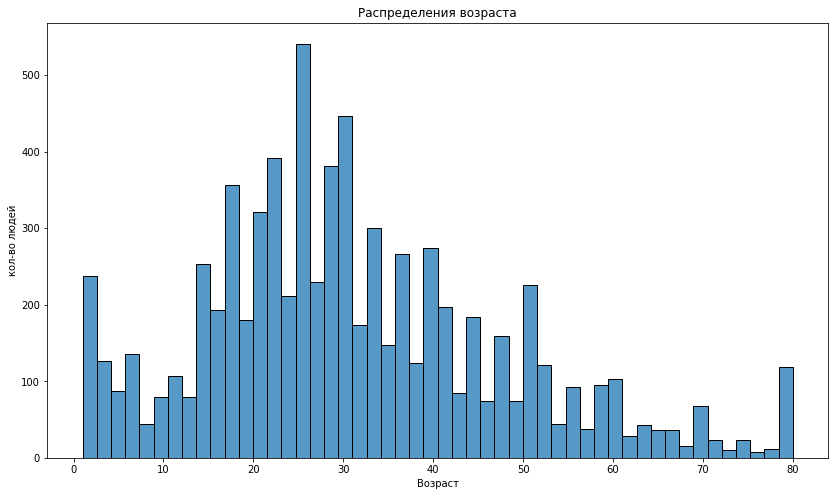

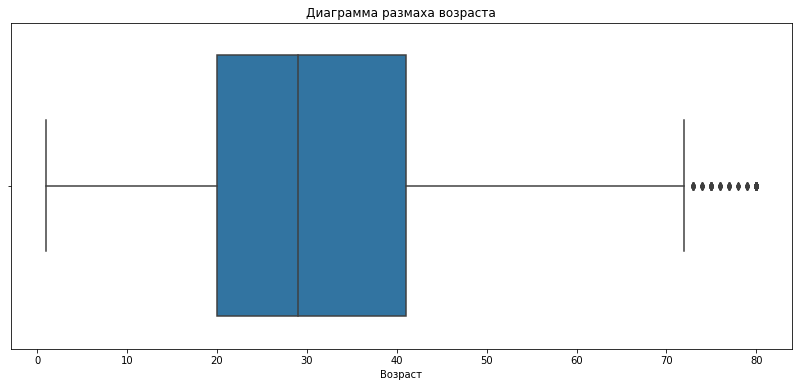

In [75]:
plt.figure(figsize=(14,8))
sns.histplot(labels['real_age'], bins=100)
plt.title("Распределения возраста")
plt.xlabel("Возраст")
plt.ylabel("кол-во людей")

plt.figure(figsize=(14,6))
sns.boxplot(labels['real_age'])
plt.title("Диаграмма размаха возраста")
plt.xlabel("Возраст");

In [65]:
for i in range(len(labels['real_age'])):
    if labels['real_age'][i]>90:
        labels['real_age'][i]=90
    if labels['real_age'][i]<=0:
        labels['real_age'][i]=1

In [78]:
x,y=next(train_gen_flow)

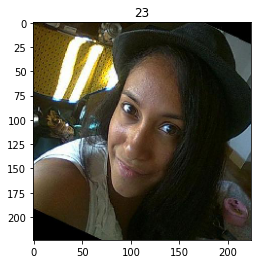

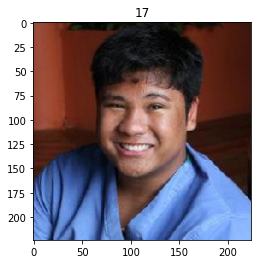

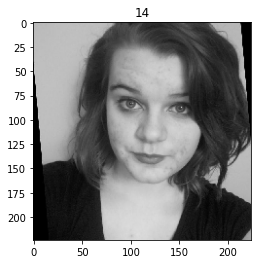

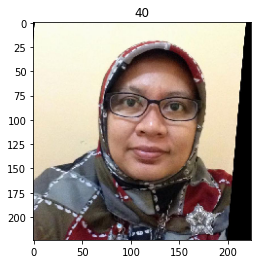

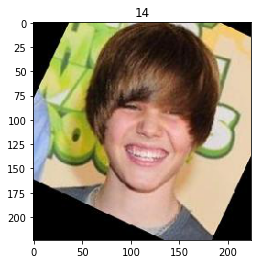

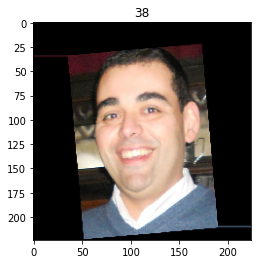

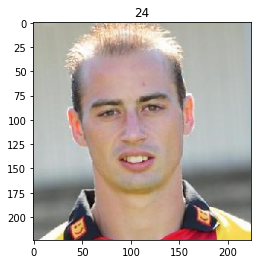

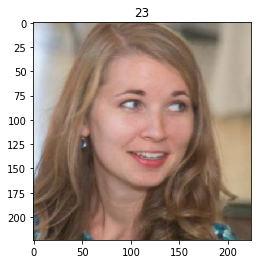

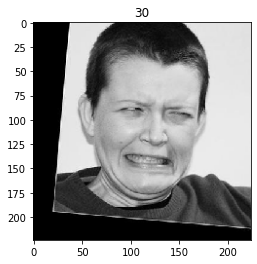

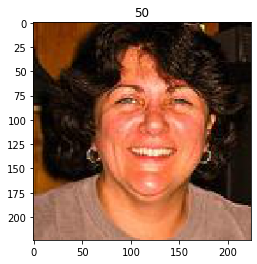

In [79]:
for i in range(10):           
    plt.imshow(x[i])
    plt.title(y[i])  
    plt.show()

<div style="padding: 30px 25px; border: 5px #FFAA00 solid">

### вывод по главе 'Исследовательский анализ данных':
   - загрузили данные
   - посомтрели общие данные и построили графики распределения возраста
   - из гистограммы  видно, что средний возраст 26-28 лет
   - убрали выбросы. Заменили возраст более 90 лет на ровно 90, 0 и меньше на 1 год
   - посмотрели как выглядят фотографии сопоставленные с возрастом
    
после визуализации стало видно, что присутствуют не совсем стандартные изоброжения, а именно есть чб изображения, также есть изображения не стандартного размера либо больше либо меньше нормы,также есть перевернутые и повернутые на не определенный угол,но большая часть изображений имеет стандартный вид
    

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    tr_datagen = ImageDataGenerator(rescale=1/255.,
                                    validation_split=0.25,
                                 vertical_flip=True)

    train_datagen_flow = tr_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=3826)


    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1/255.,
                                 validation_split=0.25)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=3826)


    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model



```

```
Epoch 1/10
356/356 - 66s - loss: 231.9811 - mae: 11.2508 - val_loss: 584.6553 - val_mae: 19.1548
Epoch 2/10
356/356 - 38s - loss: 107.3270 - mae: 7.8547 - val_loss: 188.3989 - val_mae: 10.3486
Epoch 3/10
356/356 - 37s - loss: 76.0308 - mae: 6.6265 - val_loss: 111.4329 - val_mae: 8.1641
Epoch 4/10
356/356 - 37s - loss: 56.7959 - mae: 5.7502 - val_loss: 87.7082 - val_mae: 6.8897
Epoch 5/10
356/356 - 37s - loss: 44.1728 - mae: 5.0826 - val_loss: 105.3361 - val_mae: 8.1765
Epoch 6/10
356/356 - 37s - loss: 34.4230 - mae: 4.4965 - val_loss: 84.4701 - val_mae: 6.9412
Epoch 7/10
356/356 - 37s - loss: 27.9707 - mae: 4.0685 - val_loss: 123.2039 - val_mae: 8.8548
Epoch 8/10
356/356 - 38s - loss: 23.0719 - mae: 3.6774 - val_loss: 79.8463 - val_mae: 6.6310
Epoch 9/10
356/356 - 37s - loss: 18.8985 - mae: 3.3533 - val_loss: 77.2887 - val_mae: 6.5676
Epoch 10/10
356/356 - 37s - loss: 17.2717 - mae: 3.1723 - val_loss: 77.7309 - val_mae: 6.5219

test
119/119 - 9s - loss: 77.7309 - mae: 6.5219
Test MAE: 6.5219

```

<div style="padding: 30px 25px; border: 5px #FFAA00 solid">

### вывод по главе 'Обучение модели':
   - написали 4 функции 
   - обучили модель в тренажоре с gpu
   - получили хорошую метрику качества
    
---
Параметры модели:
    
   - модель resnet50
   - функция потерь MSE
   - метрика качества MAE
   - оптимайзер Adam со значением lerning rate: 0.0001
   - размер батча 16
   - кол-во эпох 10

## Анализ обученной модели

загрузили,посмотрели данные.

обучили модель и получили значение MAE на тестовой выборке: 6.5

Это отличное значение, также эта метрика удовлетворяет условию проекта